In [1]:
import random, warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import svm
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2})


## Counterfactual estimation challenge intuition

In [29]:
def ccn_model(eta_star, beta, alpha):
    return (1 - beta - alpha)*eta_star + alpha

def eta(x, environment):
    if environment=='sinusoid':
        return .5 + .5 * np.sin(2.9*x + .1)
    elif environment=='low_base_rate_sinusoid':
        return np.piecewise(x,[
            ((-1 <= x) & (x <= .28)),
            ((.28< x) & (x <= .71)),
            ((0.71 < x) & (x <= 1))],  
            [lambda v: .5+.5 *np.sin(.4*v -1.28), 
             lambda v: .5 + .5*np.sin(12*v-4.5),
             lambda v: .081+1.9*np.power((v-.7), 2) ])
    else: 
        return np.piecewise(x,[
            ((-1 <= x) & (x <= -.5)),
            ((-.5 < x) & (x <= 0.2069)),
            ((0.2069 < x) & (x <= 0.8)),
            ((0.8 < x) & (x <= 1))],  
            [lambda v: -1.5*v-.75, 
             lambda v: 1.4*v+.7,
             lambda v: -1.5*v+1.3,
             lambda v: 1.25*v - .9 ])
    

def pi(x, do, environment):
    if environment=='uniform': 
        pi = np.ones(x.shape)
    elif environment=='sine':

        return 1-np.piecewise(x,[
            ((-1 <= x) & (x <= .5976)),
            ((.5976 < x) & (x <= 1))],  
            [lambda v: .55 + .3*np.sin(4.45*v+.65), 
             lambda v: .0001*v + .5])

    elif environment=='low_base_rate_sinusoid':
        pi = .5+.4*np.sin(2.9*x+.1)
        
#         pi = np.piecewise(x,[((-1 <= x) & (x <= -.575)),
#                 ((-.575 < x) & (x <= 0.508)),
#                 ((0.508 < x) & (x <= 1))],  
#                        [lambda v: -.5*v-.096, 
#                         lambda v: 1/(1+np.exp(-2.5*v)),
#                         lambda v: -.5*v+1.035  ])

    return pi
    
def plot_tcn(eta_star, rand_intervention, show_propensity, show_samples):
    f, axs = plt.subplots(1, 2, sharey=False, figsize=(14,5))
    
    N=200
    
    for d in [0,1]:

        # Apply CCN noise model
        if d == 0:
            alpha_0, beta_0 = .1, .15
            eta_y = ccn_model(eta_star, beta=alpha_0, alpha=beta_0)
        else:
            alpha_1, beta_1 = .2, .05
            eta_y = ccn_model(eta_star, beta=alpha_1, alpha=beta_1)

        #Sample propensity function
        obs_outcome = np.random.binomial(1, pi(x, do=d, uniform=rand_intervention), size=eta_y.size)

        # Sample from proxy counterfactual class probability funcion
        samples_x = x[obs_outcome==1]
        samples_y = np.random.binomial(1, eta_y[obs_outcome==1], size=eta_y[obs_outcome==1].size)
        
        # Class probability functions
        axs[d].plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
        axs[d].plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')

        # Propensity function
        if show_propensity:
            axs[d].plot(x, pi(x, do=d, uniform=rand_intervention), label='$\pi(x)$', color='orange', linestyle='--')

        # Samples
        if show_samples:
            axs[d].scatter(samples_x[samples_y==1], samples_y[samples_y==1], marker='+', color='black', label=f'$Y_{d}=1$')
            axs[d].scatter(samples_x[samples_y==0], samples_y[samples_y==0], marker='o', color='black', label=f'$Y_{d}=0$')

        # Plot grid
        axs[d].set_xticks(np.arange(-1.0, 1.02, .2), fontsize=20)
        axs[d].set_yticks(np.arange(0.0, 1.01, .2), fontsize=20)
        axs[d].grid(which='both')

        # Or if you want different settings for the grids:
        axs[d].grid(which='minor', alpha=0.2)
        axs[d].grid(which='major', alpha=0.5)
        # ax.set_xlim([0, 1])

        axs[d].set_ylabel('Probability', size=14)
        axs[d].set_xlabel('X', size=14)
        axs[d].tick_params(axis='x', labelsize=13)
        axs[d].tick_params(axis='y', labelsize=13)

        if d == 0:
            axs[d].set_title(r'D:=0, CCN($\alpha_0=.1, \beta_0=.15$)', size=14)
            axs[d].legend(prop={'size': 14}, loc='center right')
        else:
            axs[d].set_title(r'D:=1, CCN($\alpha_1=.2, \beta_1=.05$)', size=14)
            axs[d].legend(prop={'size': 14}, bbox_to_anchor=(1.02, 1))
        
    return f


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def learn_eta_hat(do, exp_dataset, method='IPW'):

    data = pd.DataFrame(exp_dataset)
    te_ix = int(data.shape[0]*.7)

    train = data.iloc[:te_ix]
    train_x = train['X'][train['Ds']==1].to_numpy().reshape(-1, 1)
    train_y = train['Y'][train['Ds']==1].to_numpy()
    train_dx = train['X'].to_numpy().reshape(-1, 1)
    train_d = train['Ds'].to_numpy()

    val = data.iloc[te_ix:]
    val_x = val['X'][val['Ds']==1].to_numpy().reshape(-1, 1)
    val_y = val['Y'][val['Ds']==1].to_numpy()
    
    # Train model and predict propensity on test set 
    clf_pi = MLPClassifier(alpha=0, hidden_layer_sizes=(40, 4))
    clf_pi.fit(train_dx, train_d)
    
    if method=='IPW':
        tr_pd = clf_pi.predict_proba(train_x)
        weight_t = 1/(1-tr_pd[:,1])
#         clf = MLPClassifier(alpha=0, hidden_layer_sizes=(50, 4), sample_weight=weight_t)
        clf = SVC(gamma='auto', kernel='rbf', probability=True)
        clf.fit(train_x, train_y, sample_weight=weight_t)
    else:
        clf = MLPClassifier(alpha=0, hidden_layer_sizes=(40, 4))
        clf.fit(train_x, train_y)
#     clf = SVC(gamma='auto', kernel='rbf', probability=True)
    
    
    val_py = clf.predict_proba(val_x)
    val_pd = clf_pi.predict_proba(val_x)

    return val_x, val_y, val_py, val_pd


def plot_calibration(y, py, N, alpha, beta, alpha_error, beta_error):
    x, y = calibration_curve(y, py, n_bins=20, normalize=True)
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
    plt.plot(y, x, marker = '.', label = 'Model predictions')
    print(y)
    
    leg = plt.legend(loc = 'upper left')
    plt.title(f'N={N}, alpha={alpha}, beta={beta}, alpha_error={alpha_error}, beta_error={beta_error}')
    plt.xlabel('Average Predicted Probability in each bin')
    plt.ylabel('Ratio of positives')
    plt.show()
    
     


## Dataset sample size experiment 

[0.02477052 0.06501595 0.12598719 0.174539   0.22522208 0.27846995
 0.32610471 0.37807193 0.42273802 0.47310861 0.52319231 0.57691298
 0.62607527 0.67440329 0.72671778 0.78167313 0.82460378 0.87857494
 0.92923058 0.98240565]


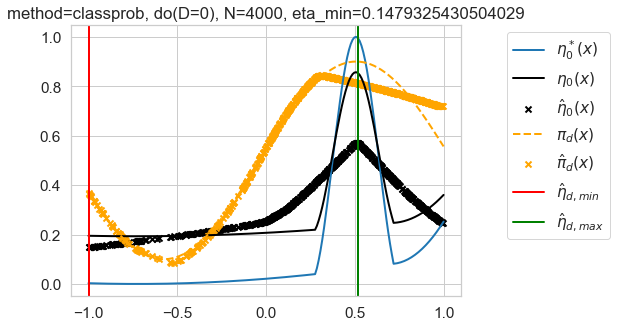

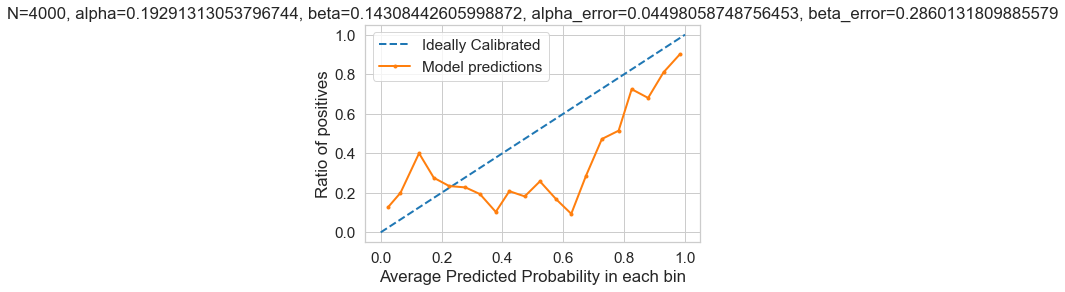

[0.02477052 0.06501595 0.12598719 0.174539   0.22522208 0.27846995
 0.32610471 0.37807193 0.42273802 0.47310861 0.52319231 0.57691298
 0.62607527 0.67440329 0.72671778 0.78167313 0.82460378 0.87857494
 0.92923058 0.98240565]


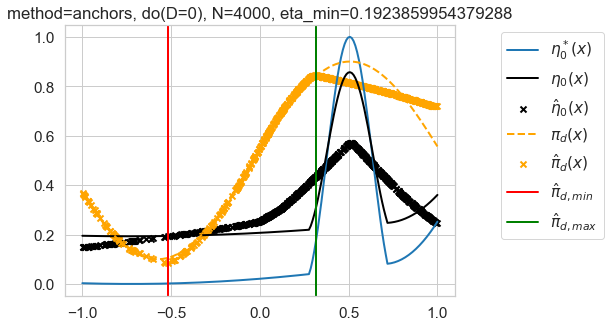

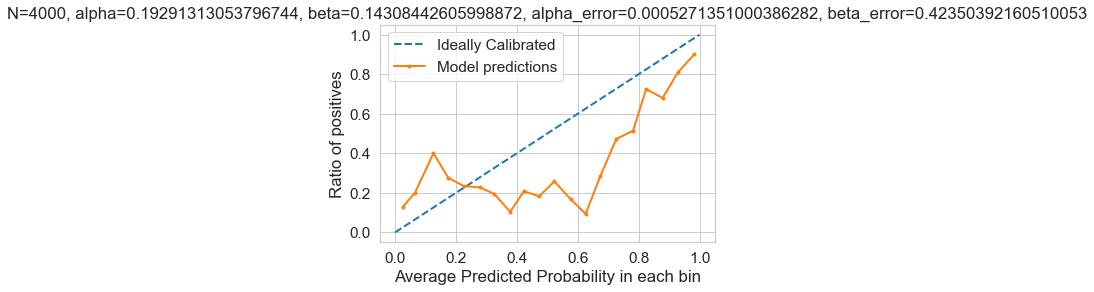

[0.01778177 0.0751378  0.12610735 0.16780214 0.21949324 0.27660544
 0.32109929 0.37415895 0.42139217 0.47845085 0.52425656 0.57631767
 0.62785381 0.67281437 0.72636224 0.77368271 0.82478656 0.87483771
 0.92741627 0.97913193]


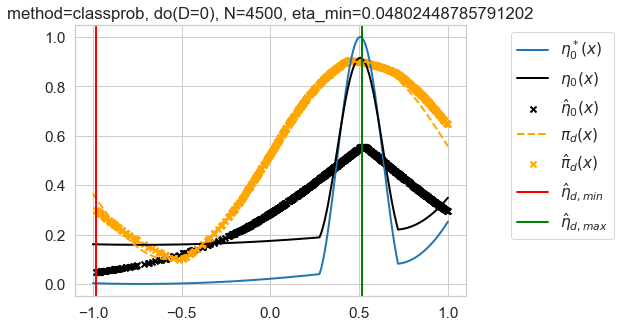

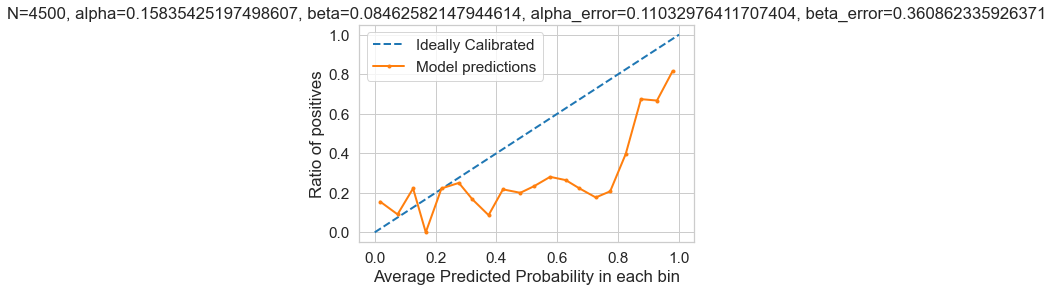

[0.01778177 0.0751378  0.12610735 0.16780214 0.21949324 0.27660544
 0.32109929 0.37415895 0.42139217 0.47845085 0.52425656 0.57631767
 0.62785381 0.67281437 0.72636224 0.77368271 0.82478656 0.87483771
 0.92741627 0.97913193]


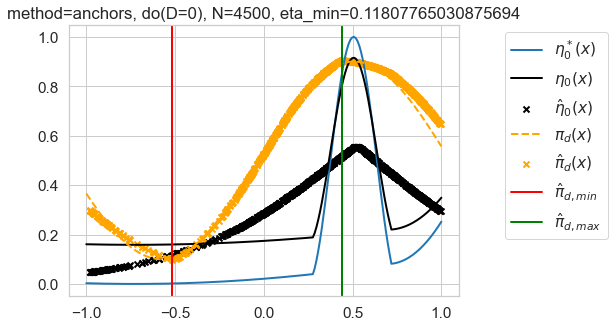

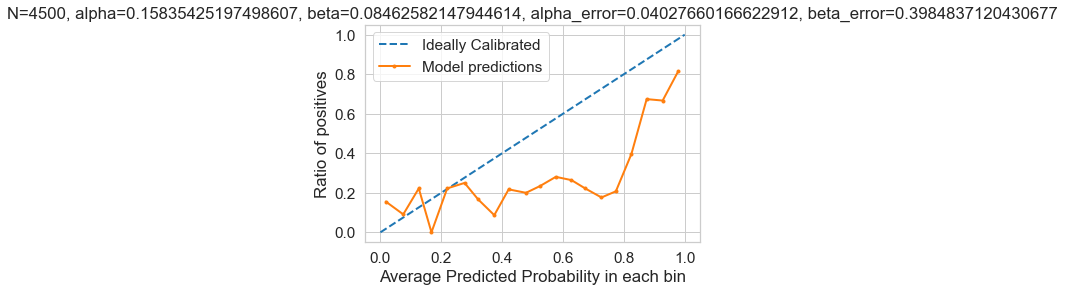

[0.01707216 0.06858125 0.11927045 0.17569372 0.22160574 0.27595275
 0.32741982 0.38002242 0.41943167 0.47822497 0.52337309 0.57777574
 0.62348974 0.6740806  0.72942766 0.77311266 0.82389538 0.87613172
 0.92741011 0.97395074]


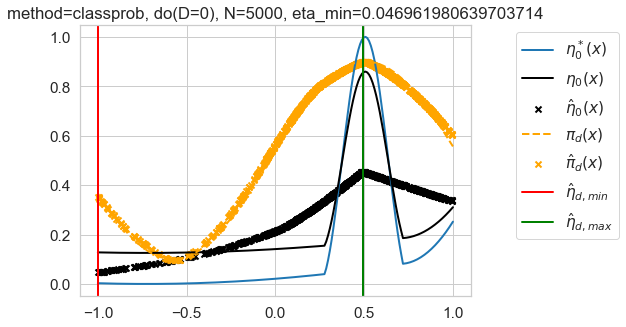

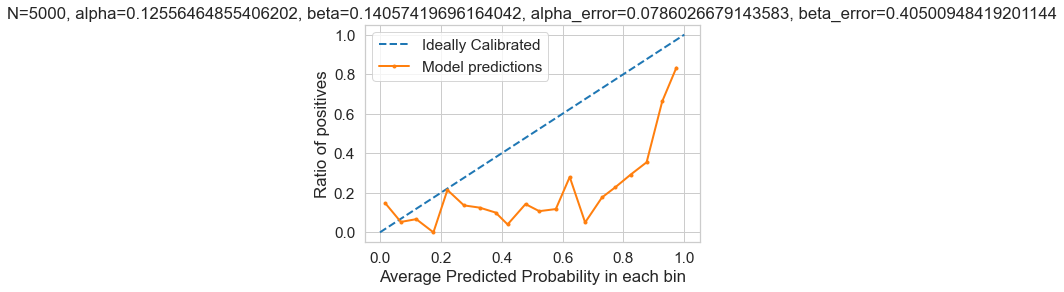

[0.01707216 0.06858125 0.11927045 0.17569372 0.22160574 0.27595275
 0.32741982 0.38002242 0.41943167 0.47822497 0.52337309 0.57777574
 0.62348974 0.6740806  0.72942766 0.77311266 0.82389538 0.87613172
 0.92741011 0.97395074]


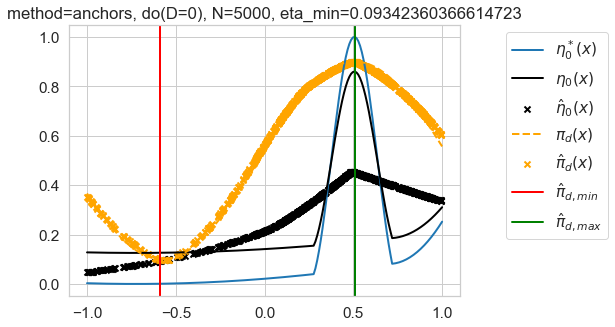

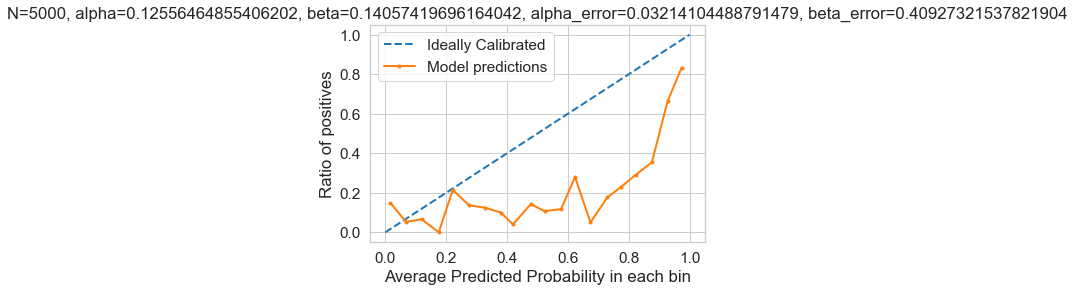

[0.02008948 0.0661802  0.12525162 0.17625931 0.2225116  0.27749753
 0.32438609 0.37426277 0.42871134 0.47349785 0.52024356 0.57117994
 0.62431521 0.6766074  0.72563243 0.77275582 0.82797216 0.87949958
 0.9236055  0.98821248]


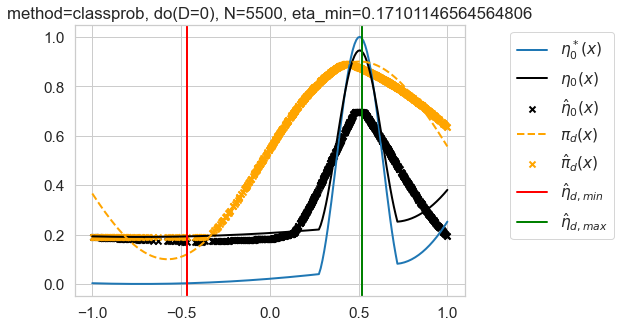

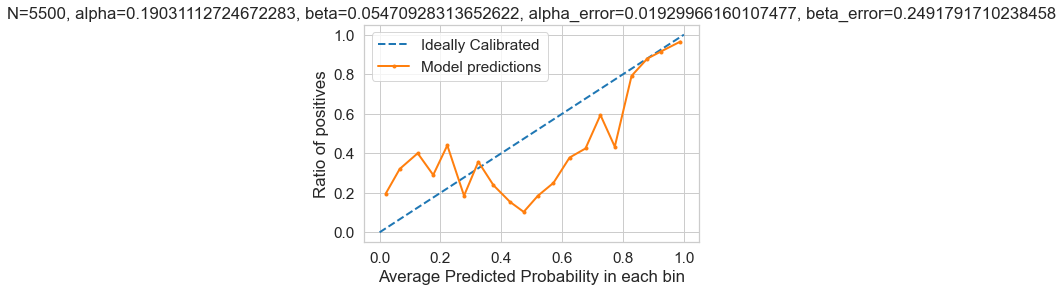

[0.02008948 0.0661802  0.12525162 0.17625931 0.2225116  0.27749753
 0.32438609 0.37426277 0.42871134 0.47349785 0.52024356 0.57117994
 0.62431521 0.6766074  0.72563243 0.77275582 0.82797216 0.87949958
 0.9236055  0.98821248]


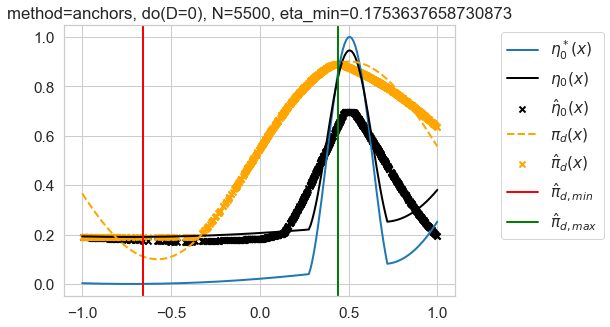

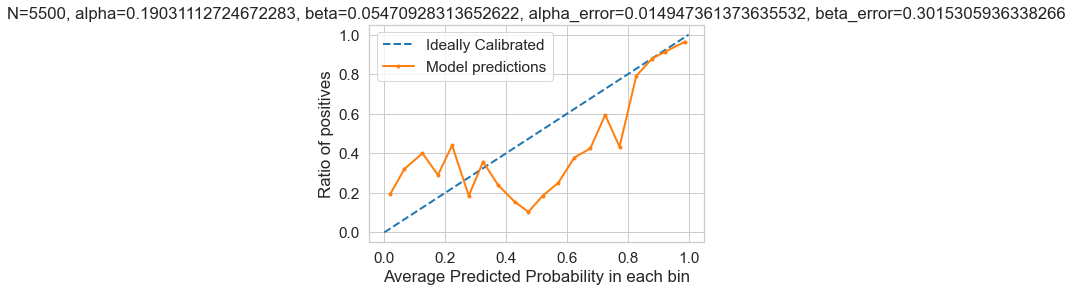

[0.0129726  0.0702578  0.1240277  0.17306854 0.22496454 0.27013088
 0.32255444 0.37998052 0.42545256 0.4742542  0.52231663 0.5739817
 0.62652417 0.68238177 0.72259006 0.77221865 0.82127326 0.87642062
 0.93085155 0.98339229]


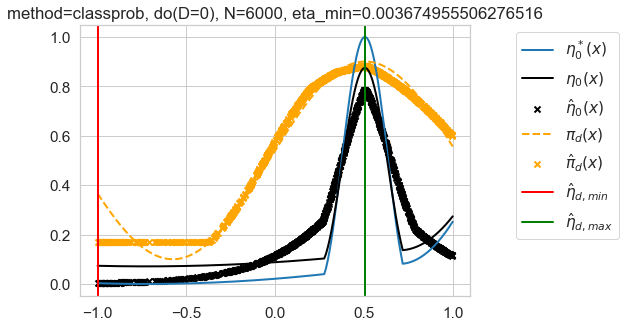

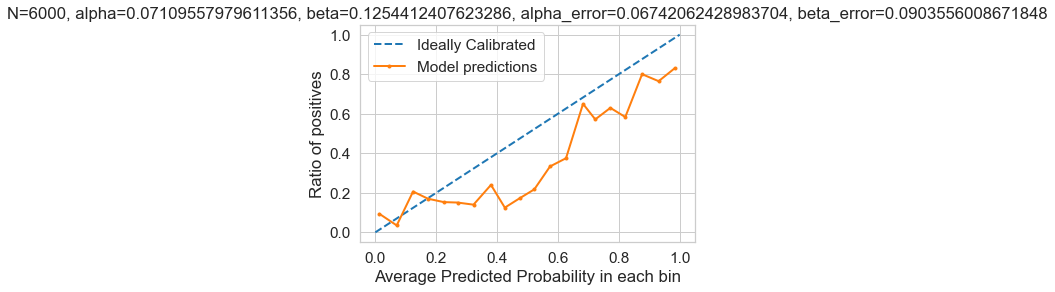

[0.0129726  0.0702578  0.1240277  0.17306854 0.22496454 0.27013088
 0.32255444 0.37998052 0.42545256 0.4742542  0.52231663 0.5739817
 0.62652417 0.68238177 0.72259006 0.77221865 0.82127326 0.87642062
 0.93085155 0.98339229]


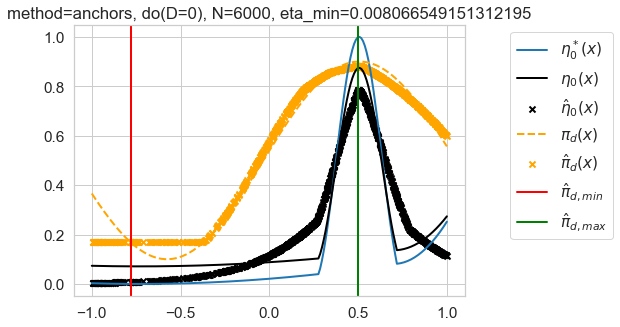

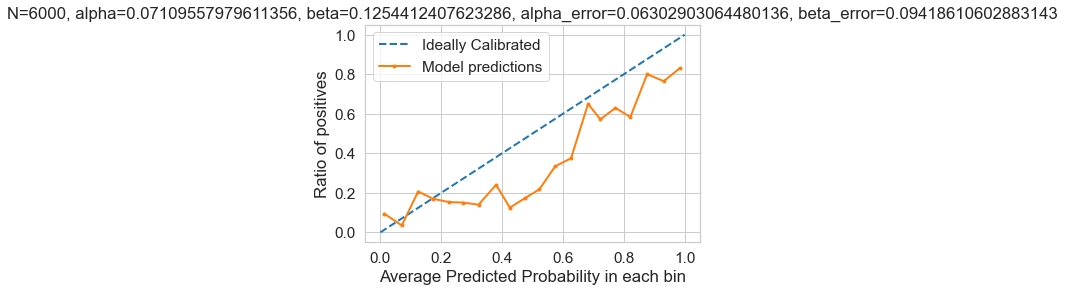

In [73]:
xmin=-1
xmax=1

# Configuration
plot=True
environment='low_base_rate_sinusoid'
dataset_sizes = [4000, 4500, 5000, 5500, 6000]

x = np.linspace(-1,1, num=200)
eta_star = eta(x, environment=environment)
d=0

runs = {
    'N': [],
    'alpha': [],
    'alpha_hat': [],
    'beta': [],
    'beta_hat': [], 
    'alpha_error': [], 
    'beta_error': [],
    'total_error': [],
    'method': []
}

for N in dataset_sizes:
    for run in range(15):
        alpha = random.uniform(.05, .2)
        beta =  random.uniform(.05, .2)

        # Sample data
        xs = np.random.uniform(xmin, xmax, size=N)
        ds = np.random.binomial(1, pi(xs, do=0, environment=environment)) #make do() instead of draw
        etass = eta(xs, environment=environment)
        eta_y = ccn_model(eta_star, beta=beta, alpha=alpha)
        pysd = ccn_model(etass, beta=beta, alpha=alpha)
        yobs = np.random.binomial(1, pysd)

        exp_dataset = {
            'X': xs,
            'Y': yobs,
            'Yps': yobs,
            'Ds': ds,
        }
        
        val_x, val_y, val_py, val_pd = learn_eta_hat(do=0, exp_dataset=exp_dataset, method='ce')
        
        # Compute estimates and errors
        pix = pi(val_x, do=d, environment=environment)
            
        for method in ['classprob', 'anchors']:
            if method=='classprob':
                ix_min = val_py[:, 1].argmin()
                ix_max = val_py[:, 1].argmax()
            elif method=='anchors':
                # Selective intervention
                ix_min = val_pd[:, 1].argmin()
                ix_max = val_pd[:, 1].argmax()

            alpha_hat = val_py[ix_min, 1]
            beta_hat = 1 - val_py[ix_max, 1]

            alpha_error = np.abs(alpha_hat-alpha)
            beta_error = np.abs(beta_hat-beta)
            total_error = alpha_error+beta_error

            # Track error statistics
            runs['N'].append(N)
            runs['alpha'].append(alpha)
            runs['beta'].append(beta)
            runs['alpha_hat'].append(alpha_hat)
            runs['beta_hat'].append(alpha_hat)
            runs['alpha_error'].append(alpha_error)
            runs['beta_error'].append(beta_error)
            runs['total_error'].append(total_error)
            runs['method'].append(method)

            if run==0 and plot:
                f, axs = plt.subplots(1, 1, sharey=False, figsize=(7,5))

                # Class probability functions
                axs.plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
                axs.plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')
                axs.scatter(val_x, val_py[:,1], marker='x', color='black', label=f'$\hat \eta_0(x)$')

                # Propensity function
                pix = pi(x, do=0, environment=environment)
                axs.plot(x, pix.squeeze(), label='$\pi_d(x)$', color='orange', linestyle='--')
                axs.scatter(val_x, val_pd[:,1], marker='x',  color='orange', label=f'$\hat \pi_d(x)$')

                if method == 'anchors':
                    axs.axvline(x=val_x[ix_min], color='red', label='$\hat \pi_{d,min}$')
                    axs.axvline(x=val_x[ix_max], color='green', label='$\hat \pi_{d,max}$')
                elif method == 'classprob':
                    axs.axvline(x=val_x[ix_min], color='red', label='$\hat \eta_{d,min}$')
                    axs.axvline(x=val_x[ix_max], color='green', label='$\hat \eta_{d,max}$')

                plt.title(f'method={method}, do(D={d}), N={N}, eta_min={val_py[ix_min, 1]}', )
                plt.legend(bbox_to_anchor=(1.4, 1))
#                 plt.savefig(f'fig/do(D={d}), N={N} anchors.png', dpi=400, bbox_inches = "tight")

                plot_calibration(val_y, val_py[:, 1], N=N, alpha=alpha, beta=beta, alpha_error=alpha_error, beta_error=beta_error)


In [2]:
runslog = pd.DataFrame(runs)

# runslog=runslog.rename(columns={
#     'alpha_error': 'Alpha',
#     'beta_error': 'Beta',
# }, inplace=False)

data = pd.melt(runslog, id_vars=['N', 'alpha', 'beta', 'alpha_hat', 'beta_hat', 'total_error', 'method'],
        value_vars=['alpha_error', 'beta_error'], value_name='error')

# data.loc[data['method'] == 'classprob', 'method'] = '$\hat \eta_{d,min} / \hat \eta_{d,max}$'
# data.loc[data['method'] == 'anchors', 'method'] = '$\hat \pi_{d,min} / \hat \pi_{d,max}$'

NameError: name 'runs' is not defined

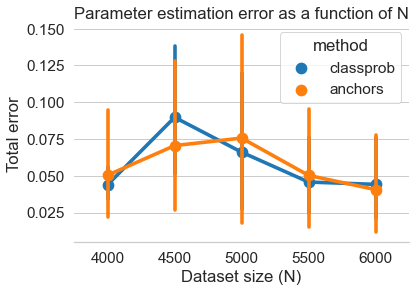

In [80]:
t


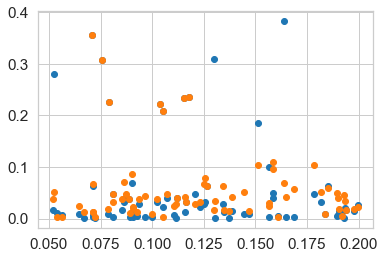

In [76]:
runslog = pd.DataFrame(runs)

compdf = pd.DataFrame({
    'anchor_alpha_error': runslog[runslog['method']=='anchors']['alpha_error'].values,
    'classprob_alpha_error': runslog[runslog['method']=='classprob']['alpha_error'].values,
    'alpha': runslog[runslog['method']=='anchors']['alpha'].values
})


plt.scatter(compdf['alpha'], compdf['anchor_alpha_error'] )
plt.scatter(compdf['alpha'], compdf['classprob_alpha_error'] )

# data[data['method'] == 'anchors'] 

# - data[data['method'] == 'classprob']

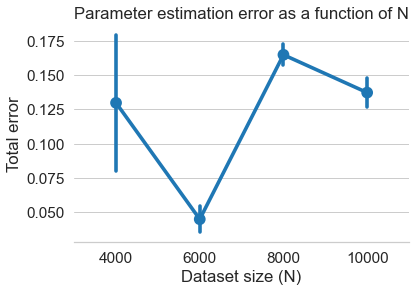

In [7]:
sns.pointplot(data=data, x='N', y='total_error')
plt.ylabel('Total error')
plt.xlabel('Dataset size (N)')
plt.title('Parameter estimation error as a function of N')
sns.despine(left=True)
plt.savefig('fig/total_error.png')

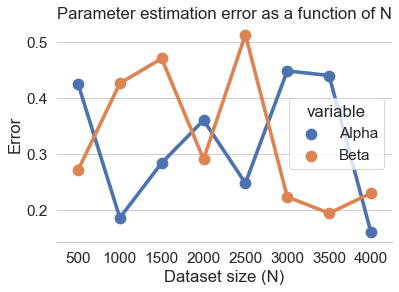

In [169]:
runslog = pd.DataFrame(runs)

runslog=runslog.rename(columns={
    'alpha_error': 'Alpha',
    'beta_error': 'Beta',
}, inplace=False)

data = pd.melt(runslog, id_vars=['N', 'alpha', 'beta', 'alpha_hat', 'beta_hat', 'total_error', 'method'],
        value_vars=['Alpha', 'Beta'], value_name='error')


data = data[data['method']=='anchors']
sns.pointplot(data=data, x='N', y='error', hue='variable', palette="deep")
plt.ylabel('Error')
plt.xlabel('Dataset size (N)')
plt.title('Parameter estimation error as a function of N')
sns.despine(left=True)
plt.savefig('fig/total_alpha_beta_error.png')